# TODO
1. Document and structure

2. Data preparation

3. Add more checkpoint

4. use TSNE detect outlier
   - analyze why anomaly point happen

5. Optimize model and hyperparameter
   - show accuracy
   - analyze training data

6. How to save model

7. Use tensorflow serving/tensorflow deployment

8. use Tensorboard to analyze training process

9. Demo preparation

# Network Traffic Prediction
In this notebook, I'll build a LSTM model on bluemix network traffic. It'll be used to predict network traffic of future in those nodes.

## Problem Description

The problem that we'll work on is the network traffic prediction problem for Bluemix platform. By using the Bluemix network data (received & transferred) collected within a 2-month period, we shall build a LSTM model to predict the future network trend.

## Environment Preparation

Before we start working on the data, we need to import the following packages to set up the environment.

In [17]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Network Traffic Data from Swift Object Storage

Now we can load the Bluemix network traffic data to this notebook. The data were provided via 6 CSV files, which we have uploaded to DSX. Thus, the data files are now stored in Bluemix object storage.

### Setup Username/Password of Swift 

Since we'll later publish this notebook to a public Github, we need to set the object storage credentials in a hidden cell to avoid the leaking of account information.  

In [18]:
# The code was removed by DSX for sharing.

###  Define the load_file Function

In [19]:

from io import StringIO
import requests
import json
import pandas as pd
def load_file(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': name,'domain': {'id':domain_id },
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)


### List CSV Files used for Training
There are six CSV files stored in object storage, which will be used for training.

In [20]:
data_files=['env5_brain_192.155.247.207_20170401_20170601.csv',
            'env5_brain_169.55.245.30_20170401_20170601.csv',
            'env5_brain_169.54.213.198_20170401_20170601.csv',
            'env5_brain_10.143.131.55_20170401_20170601.csv',
            'env5_brain_10.143.123.125_20170401_20170601.csv',
            'env5_brain_10.107.77.247_20170401_20170601.csv']


### Load CSV Files to memory
Load the 6 CSV files to memory by using the ``load_file`` function defined above.

In [21]:
dataframes=[]
for data_file in data_files:
    dataframes.append(pd.read_csv(load_file(container, data_file)))


## Data preparation
As we have now loadded the CSV files to this notebook, we need to analyze the datasets to prepare the data for modelling. The 6 CSV files represent the received and transferred network flow of 6 Bluemix nodes, accross the same time period of about 60 days. The **timestamp** colume in the CSV files indicates the time when the network data was collected, while each timestamp is separated by the same interval of 5 minutes. 

Since the 6 Bluemix nodes come from the same cluster and share workload within the cluster, we will merge the network traffic data in the 6 CSV files to form a new dataset for modelling. To do this, we first need to retrieve the timestamp series as we will merge the network data with the same timestamp. Once done, we will need to normalize the dataset by rescaling the data values to the range of 0-to-1, which is a good practice for using the LSTM model.

In conclusion, for this section, we will prepare the data with the following steps:
 - retrieve timestamp series
 - merge six datasets into one 
 - normalize dataset

### Retrieve Timestamp Series
Retrieve all timestamp list in data files 

In [47]:
timestamps=set()
for data in dataframes:
    for t in (data['timestamp']):
        timestamps.add(t)

ts=sorted(timestamps)

ts_2_idx={}
idx_2_ts={}
idx=0
for timestamp in ts:
    ts_2_idx[timestamp]=idx
    idx_2_ts[idx]=timestamp
    idx+=1

## Merge six dataset into one dataset
Since all those nodes are in same cluster and only one node is under Active mode at one time. Should merge all traffic from different nodes and analyze those data later

In [23]:
merged_input=np.empty(shape=(0,2))
for t in ts:
    sum_received=0
    sum_transferred=0
    for dataframe in dataframes:
        i=dataframe[dataframe['timestamp']==t]
        cur_received=i.get('net_received',0)
        cur_transfer=i.get('net_transferred',0)
        for ind in cur_transfer.index:
            sum_transferred+=cur_transfer[ind]
        for ind in cur_received.index:
            sum_received+=cur_received[ind]
    merged_input=np.append(merged_input,[[sum_received,sum_transferred]],axis=0)


## Display net_received traffic graph  

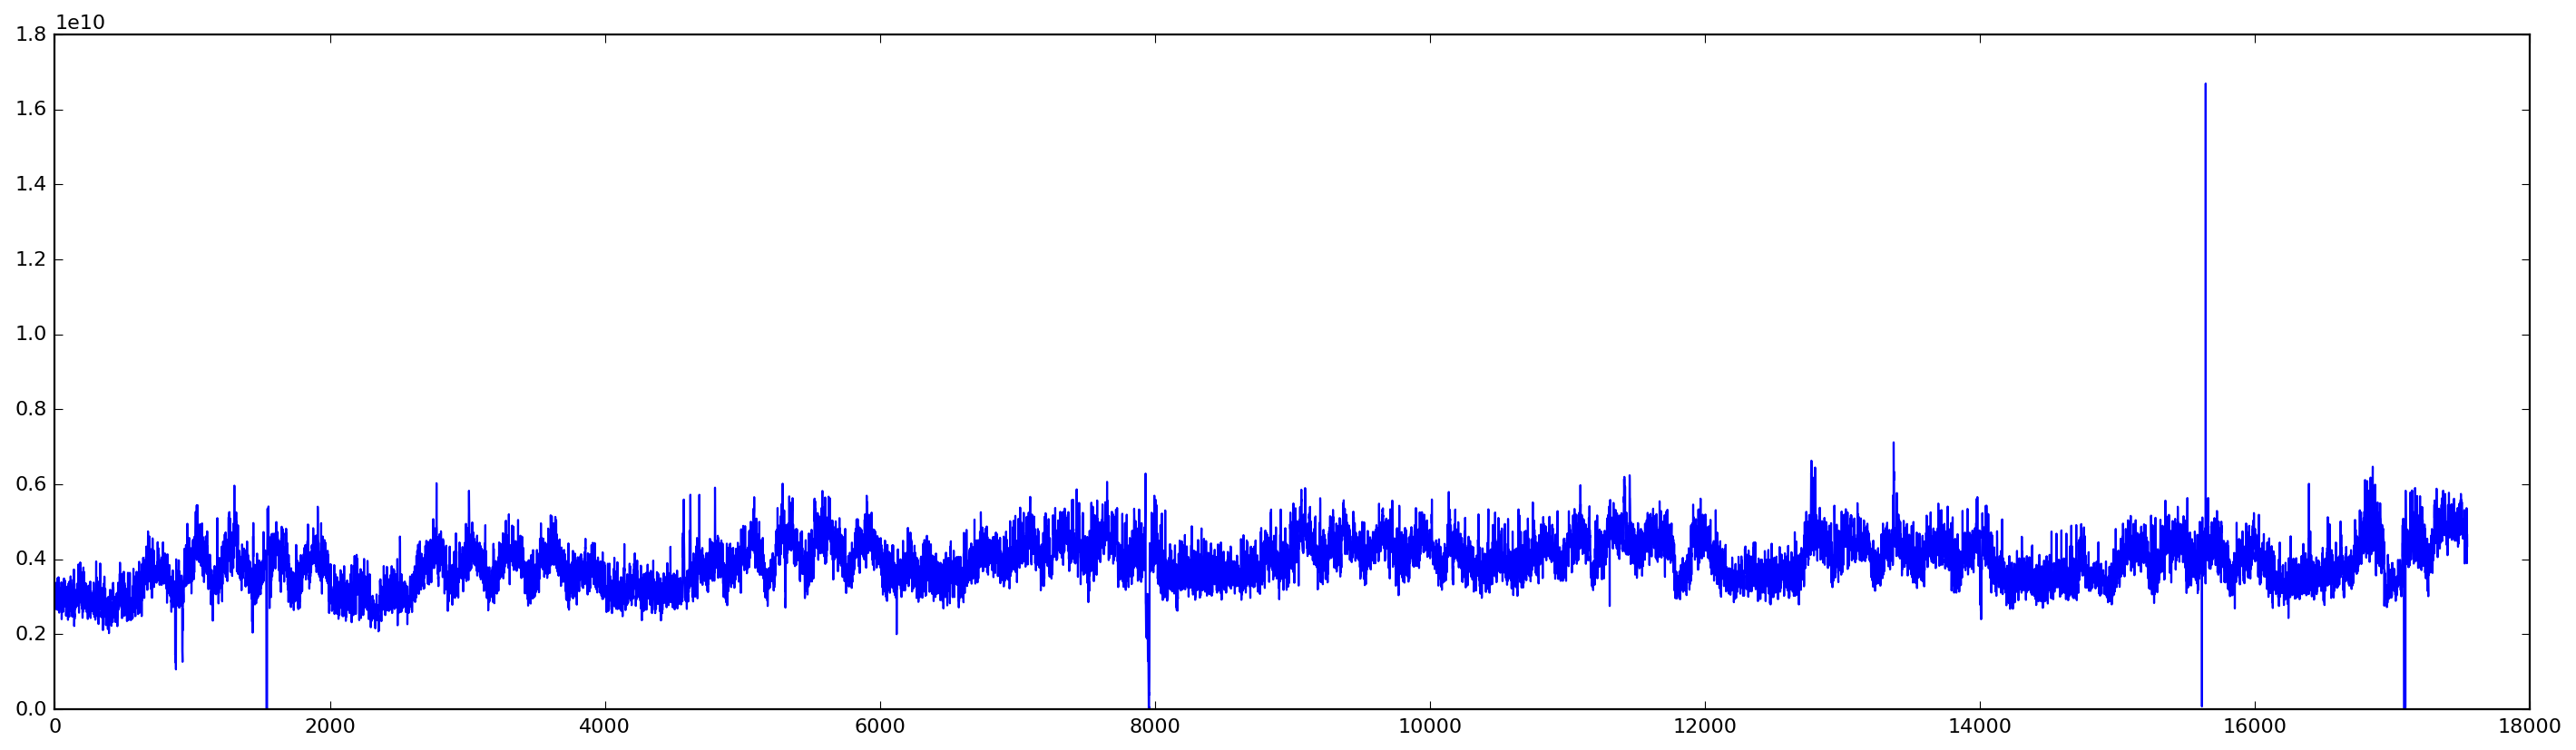

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,6), dpi=80)
plt.plot(merged_input[:,0:1])

## Display net_trasferred traffic graph  

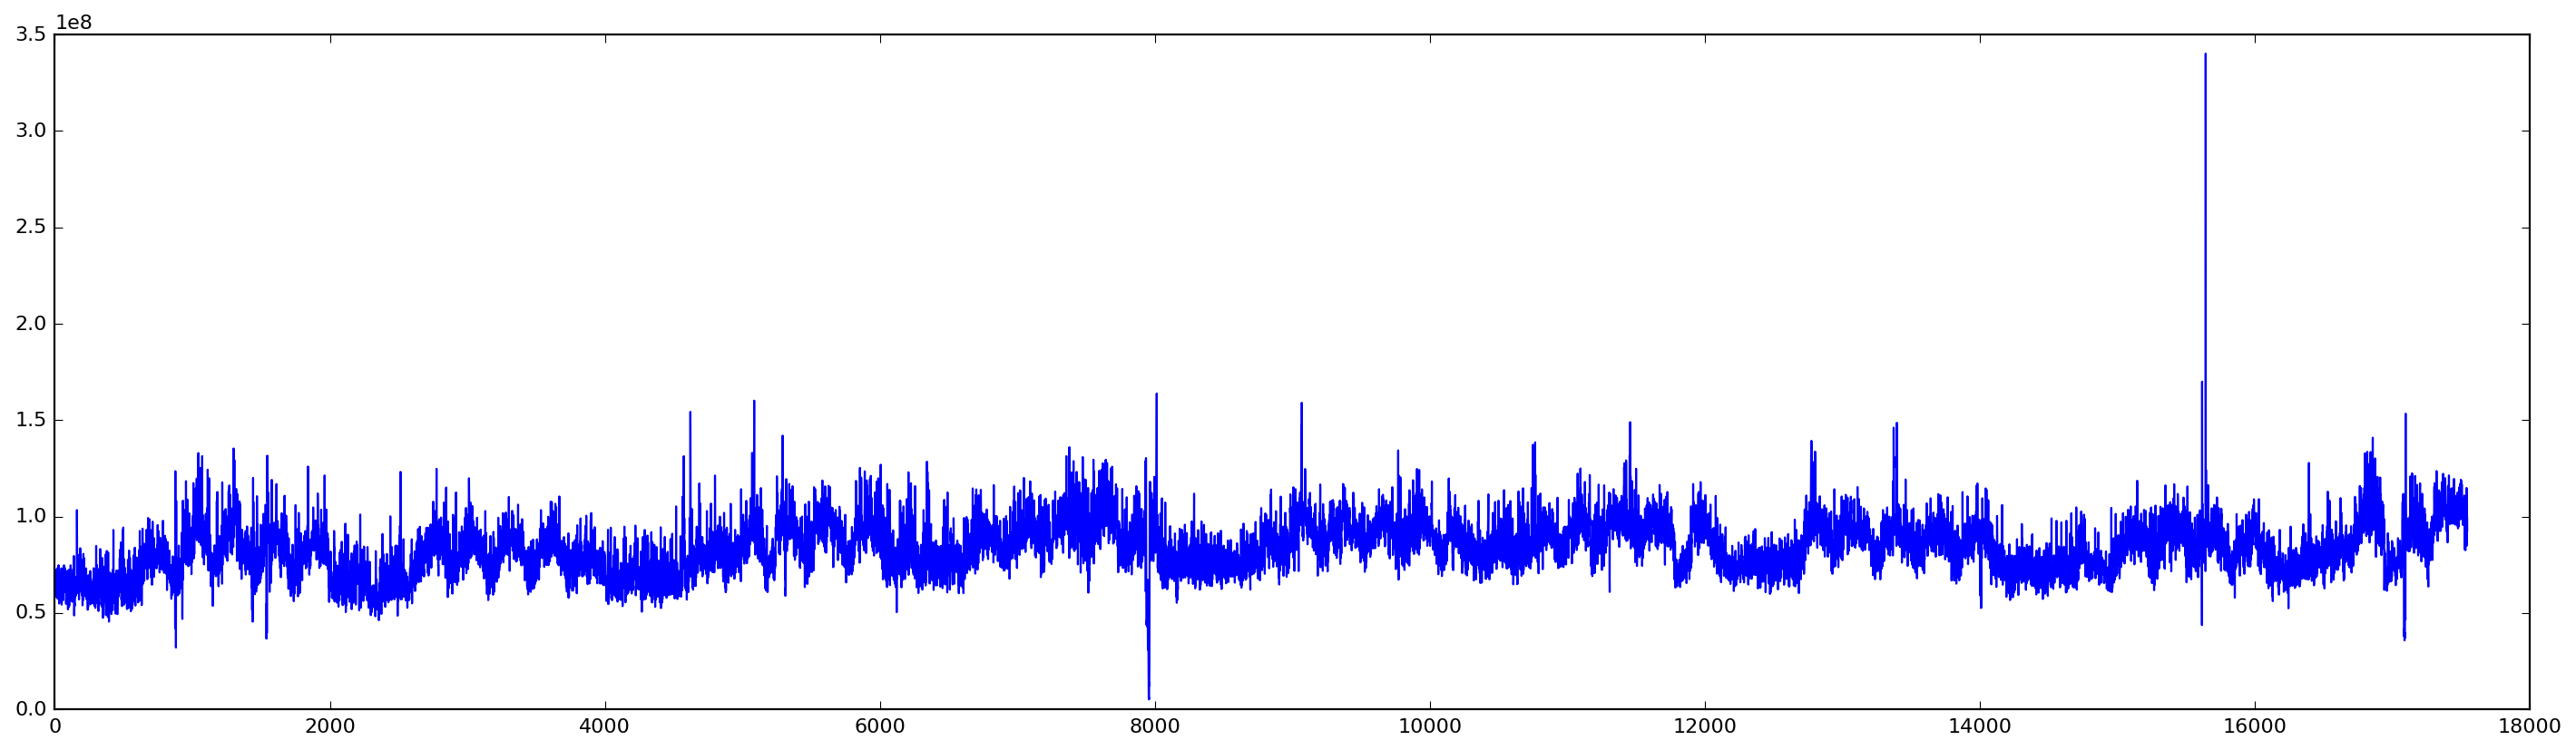

In [25]:
plt.figure(figsize=(22,6), dpi=80)
plt.plot(merged_input[:,1:2])

## Compute Hourly Network traffic

In [26]:
hourly_input=np.empty(shape=(0,2))
size=merged_input.shape[0]
for i in range(0,size,12):
    slice=merged_input[i:i+12,:]
    hourly_rev=0
    hourly_transfer=0
    for s in slice:
        hourly_rev+=s[0]
        hourly_transfer=s[1]
    hourly_input=np.append(hourly_input,[[hourly_rev,hourly_transfer]],axis=0)

## Display hourly network traffic graph  

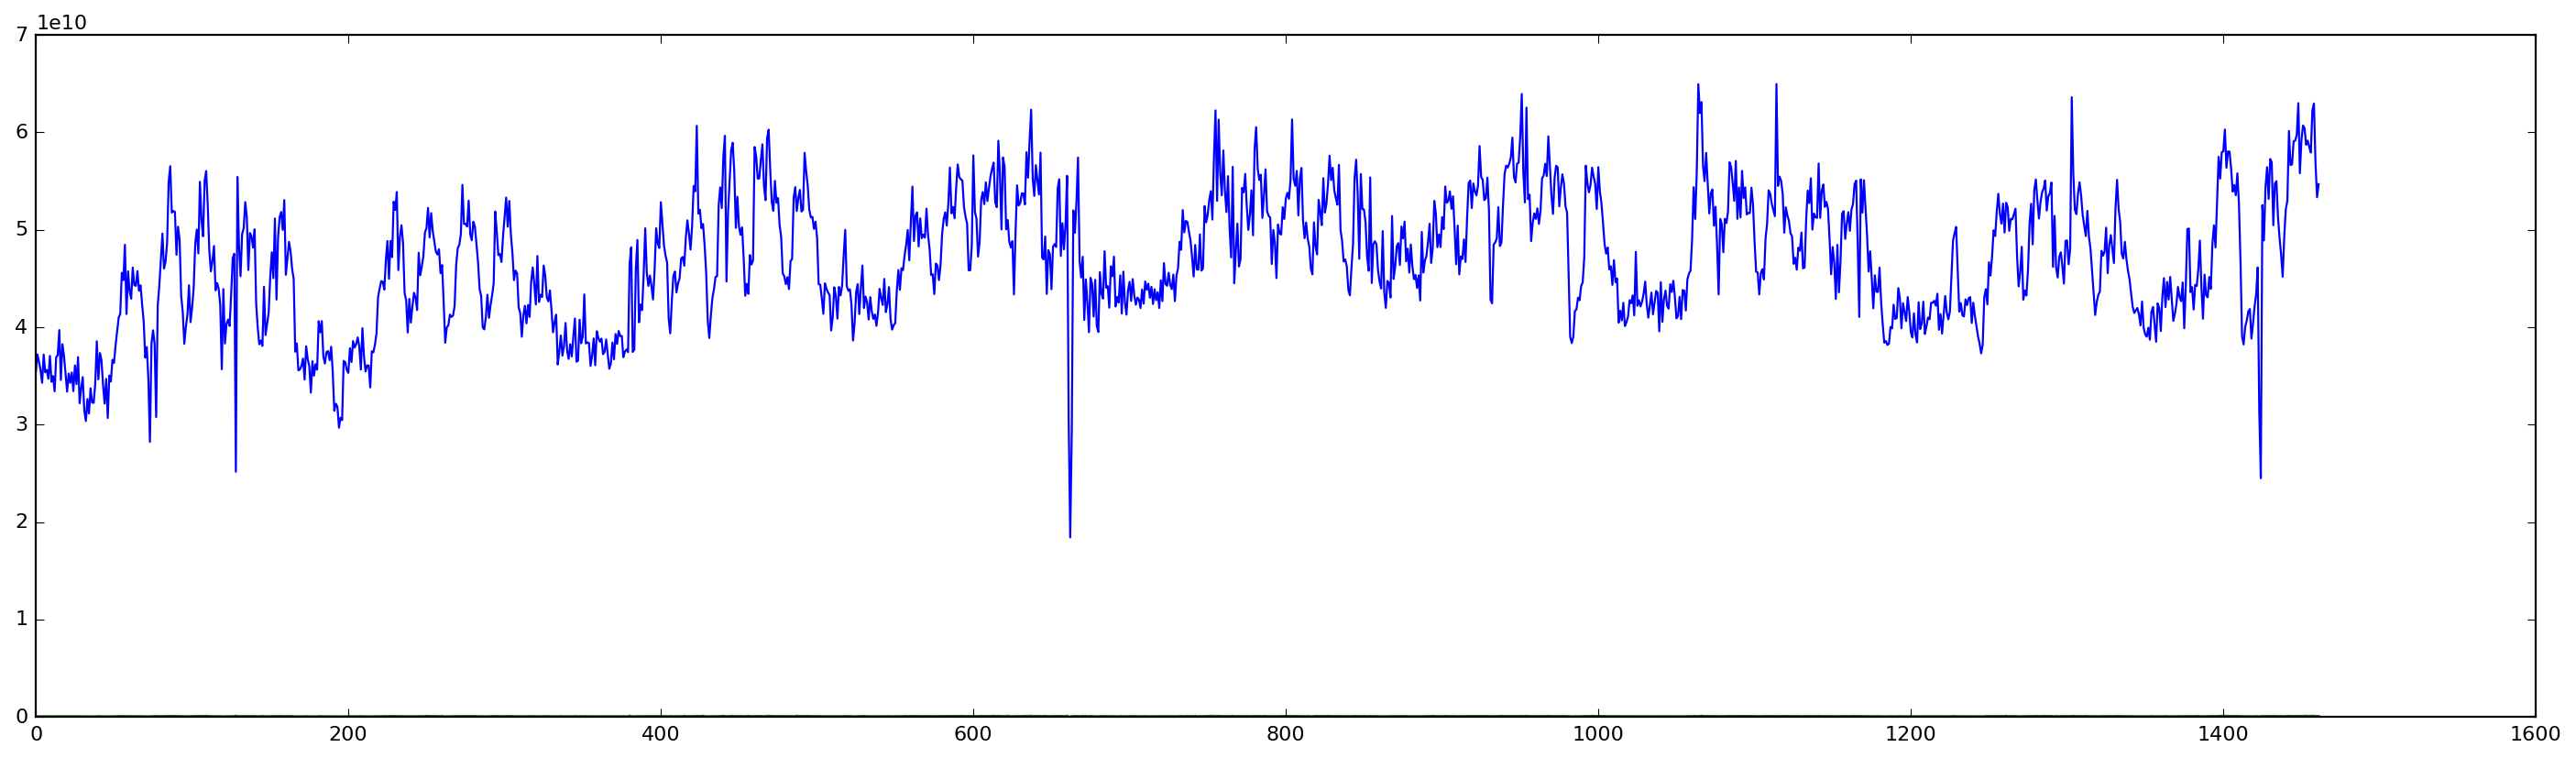

In [27]:
plt.figure(figsize=(22,6), dpi=80)
plt.plot(hourly_input)

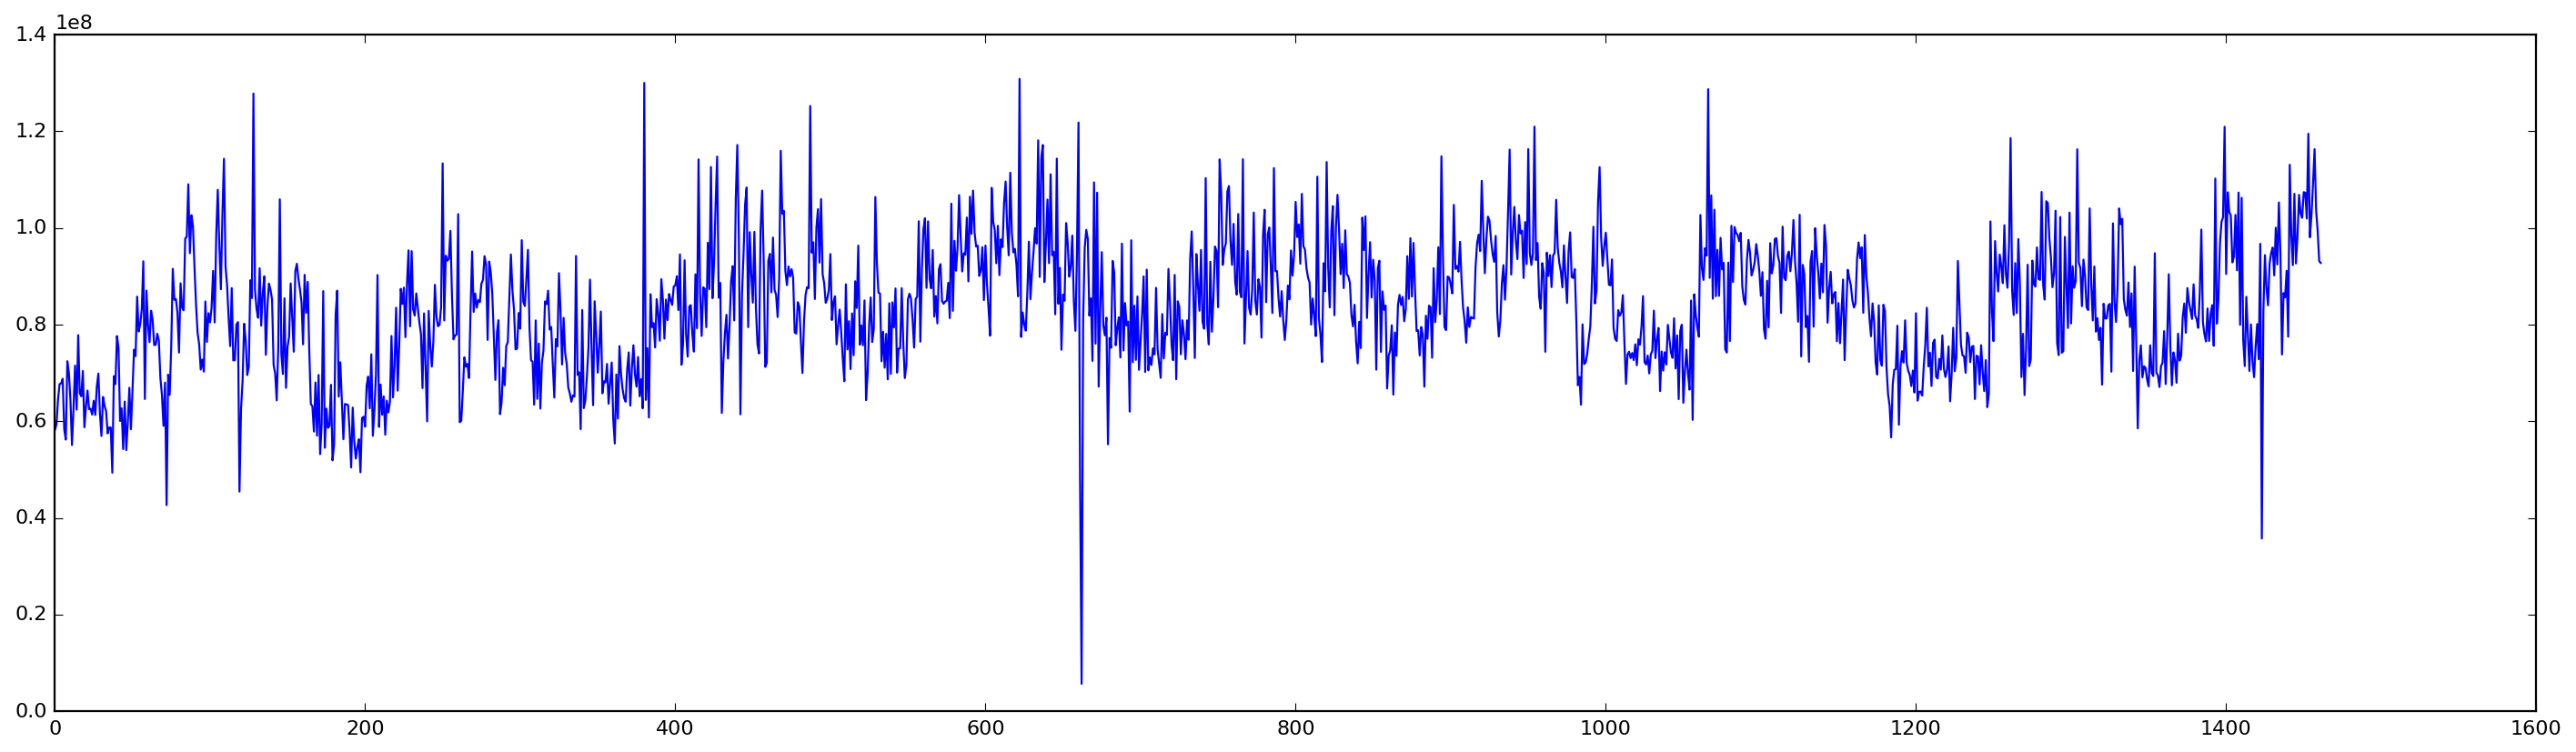

In [107]:
plt.figure(figsize=(22,6), dpi=80)

plt.plot(hourly_input[:,1:2])

## Analyze Outlier point
TODO


# Normalize data into (0,1) 

In [113]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_receive = scaler.fit_transform(hourly_input[:,0:1])

scaler2 = MinMaxScaler(feature_range=(0, 1))
dataset_transfer = scaler2.fit_transform(hourly_input[:,1:2])

# Plot diagram after data normalization

Plot diagram for network traffic after data normalization. The recieved network traffic is plot in blue, while the transferred traffic is plot in green. We can see that both traffic data follow the same trend.

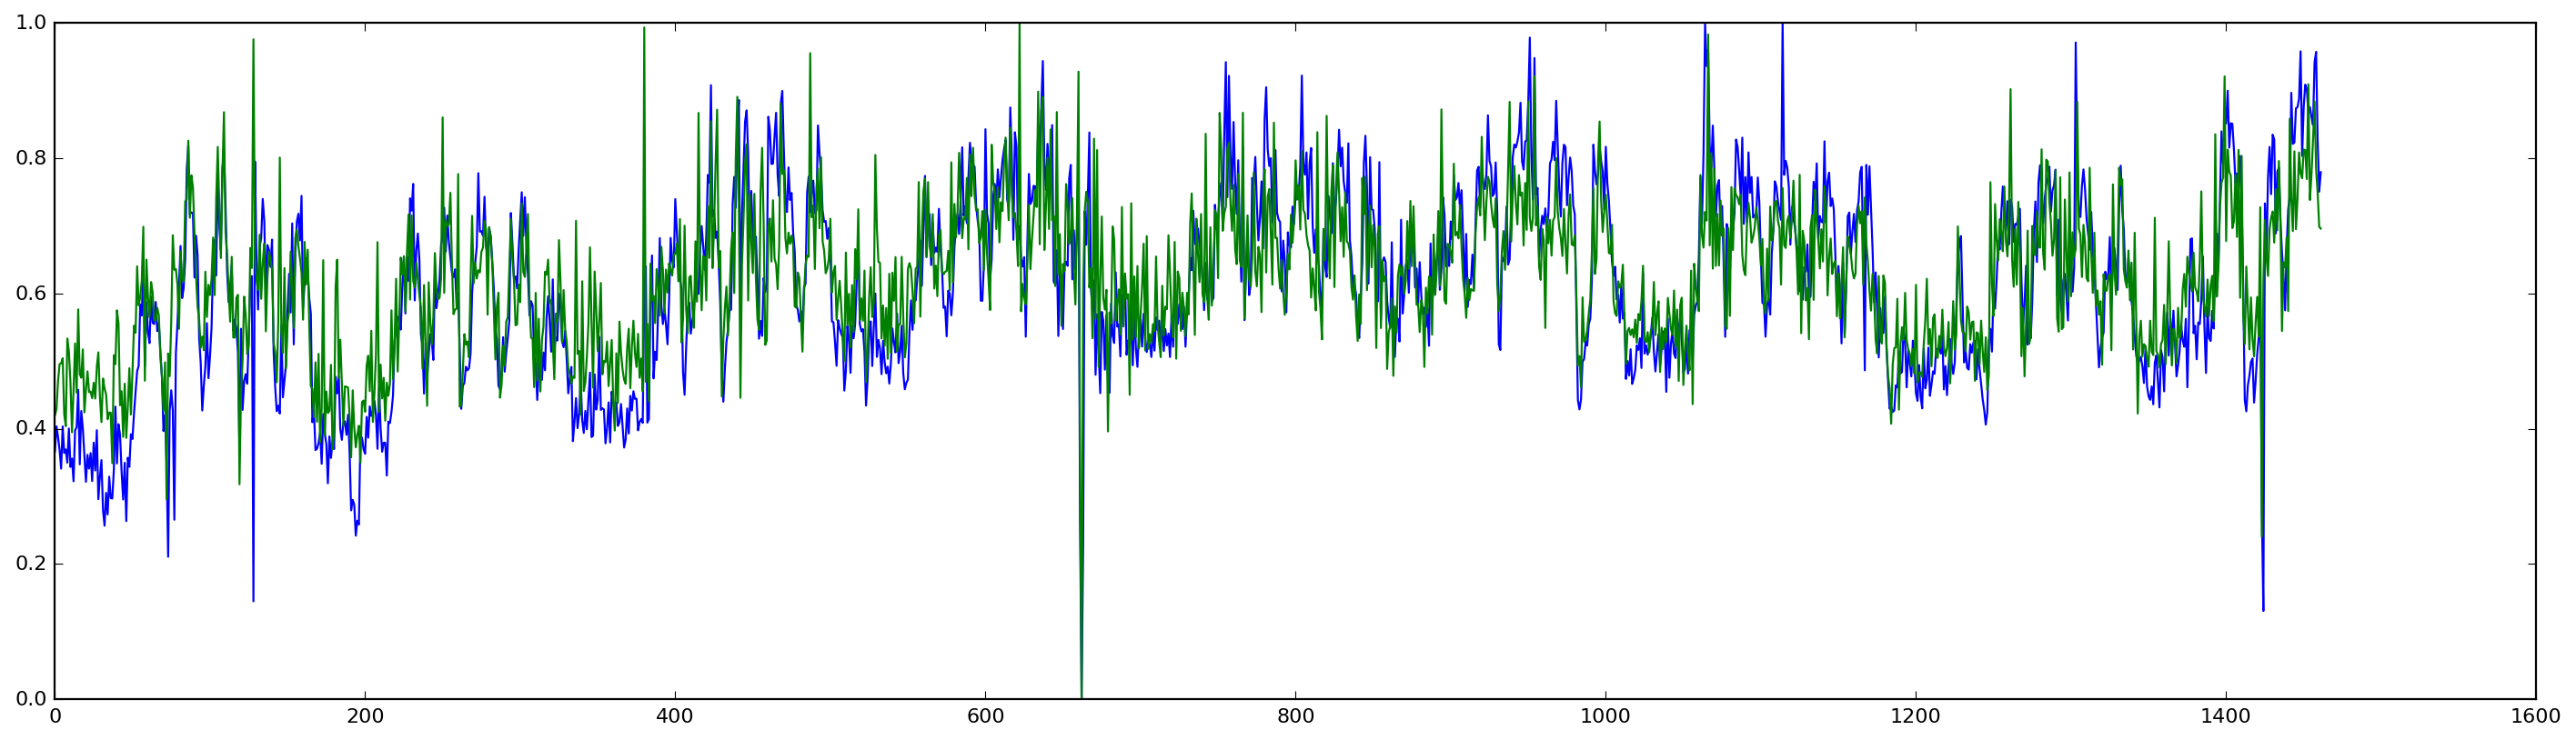

In [87]:
plt.figure(figsize=(22,6), dpi=80)
plt.plot(dataset_receive, color="blue")
plt.plot(dataset_transfer, color="green")

# Build Model

## Making training mini-batches

In [33]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Split data into training data and test data
Split data for the received network traffic dataset.

In [56]:
# split into train and test sets
train_size = int(len(dataset_receive) * 0.67)
test_size = len(dataset_receive) - train_size
train, test = dataset_receive[0:train_size,:], dataset_receive[train_size:len(dataset_receive),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Split data for the transferred network traffic dataset.

In [42]:
# split into train and test sets
train_size = int(len(dataset_transfer) * 0.67)
test_size = len(dataset_transfer) - train_size
train_transfer, test_transfer = dataset_transfer[0:train_size,:], dataset_transfer[train_size:len(dataset_transfer),:]
# reshape into X=t and Y=t+1
look_back = 1
train_transferX, train_transferY = create_dataset(train_transfer, look_back)
test_transferX, test_transferY = create_dataset(test_transfer, look_back)
# reshape input to be [samples, time steps, features]
train_transferX = np.reshape(train_transferX, (train_transferX.shape[0], 1, train_transferX.shape[1]))
test_transferX = np.reshape(test_transferX, (test_transferX.shape[0], 1, test_transferX.shape[1]))

# Create Model
In this section, 2 layer model will be created. First layer is lstm and second layer is fully connected layer.

Create model for received network dataset:

In [89]:
# fix random seed for reproducibility
np.random.seed(7)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


Create model for transferred network dataset:

In [93]:
# create and fit the LSTM network
model_transfer = Sequential()
model_transfer.add(LSTM(4, input_shape=(1, look_back)))

model_transfer.add(Dense(1))
model_transfer.compile(loss='mean_squared_error', optimizer='adam')

# Train Model

## Training Parameter 

In [90]:
epochs=10

In [ ]:
model.fit(trainX, trainY, nb_epoch=epochs, batch_size=1, verbose=2)

Epoch 1/10
4s - loss: 2194136142739620233216.0000
Epoch 2/10
3s - loss: 2194136142739620233216.0000
Epoch 3/10
3s - loss: 2194136142739620233216.0000
Epoch 5/10
3s - loss: 2194136142739620233216.0000
Epoch 6/10
4s - loss: 2194136142739620233216.0000
Epoch 7/10
4s - loss: 2194136142739620233216.0000
Epoch 8/10
3s - loss: 2194136142739620233216.0000
Epoch 9/10
4s - loss: 2194136142739620233216.0000
Epoch 10/10
3s - loss: 2194136142739620233216.0000


In [94]:
model_transfer.fit(train_transferX, train_transferY, nb_epoch=epochs, batch_size=1, verbose=2)

Epoch 1/10
4s - loss: 0.0373
Epoch 2/10
3s - loss: 0.0089
Epoch 3/10
4s - loss: 0.0089
Epoch 4/10
3s - loss: 0.0086
Epoch 5/10
3s - loss: 0.0086
Epoch 6/10
3s - loss: 0.0085
Epoch 7/10
3s - loss: 0.0085
Epoch 8/10
3s - loss: 0.0085
Epoch 9/10
3s - loss: 0.0085
Epoch 10/10
3s - loss: 0.0084


# Save Training Model
Todo

# Predict through Model
Predict through model for received network traffic.

In [59]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_origin = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_origin = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_origin[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_origin[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_receive)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_receive)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_receive)-1, :] = testPredict



Train Score: 3506661697.05 RMSE
Test Score: 3254699275.70 RMSE


## Training and Predict diagram  

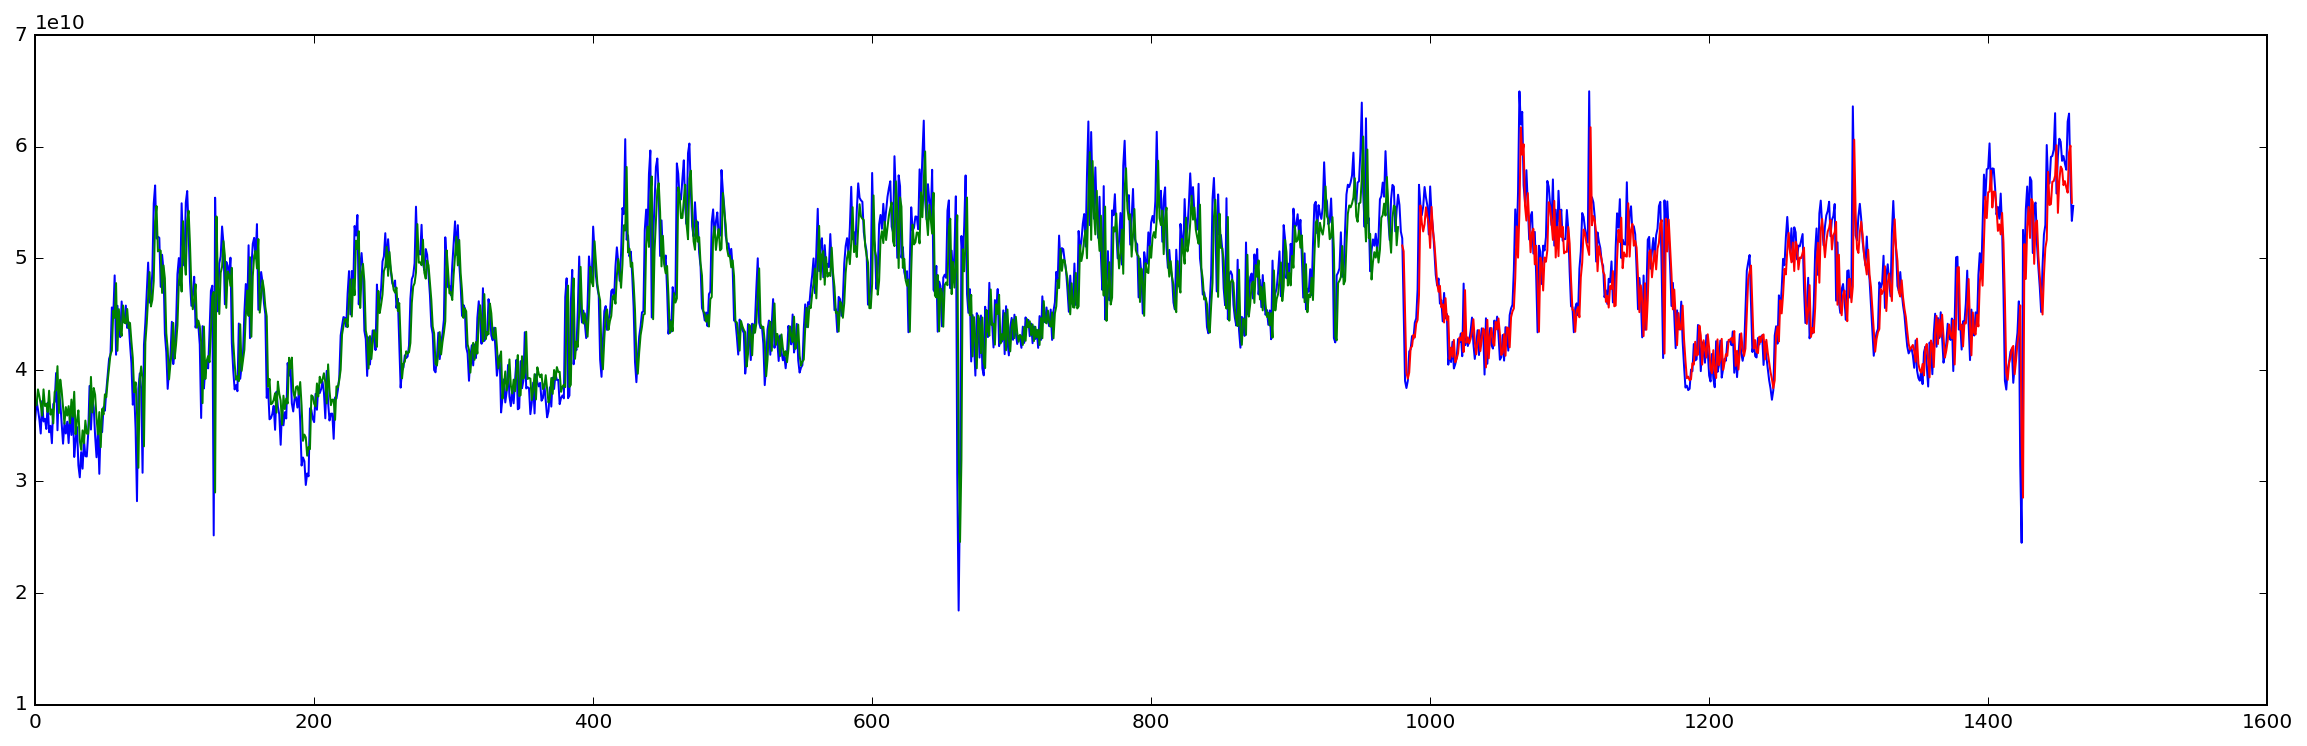

In [60]:
# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(scaler.inverse_transform(dataset_receive))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

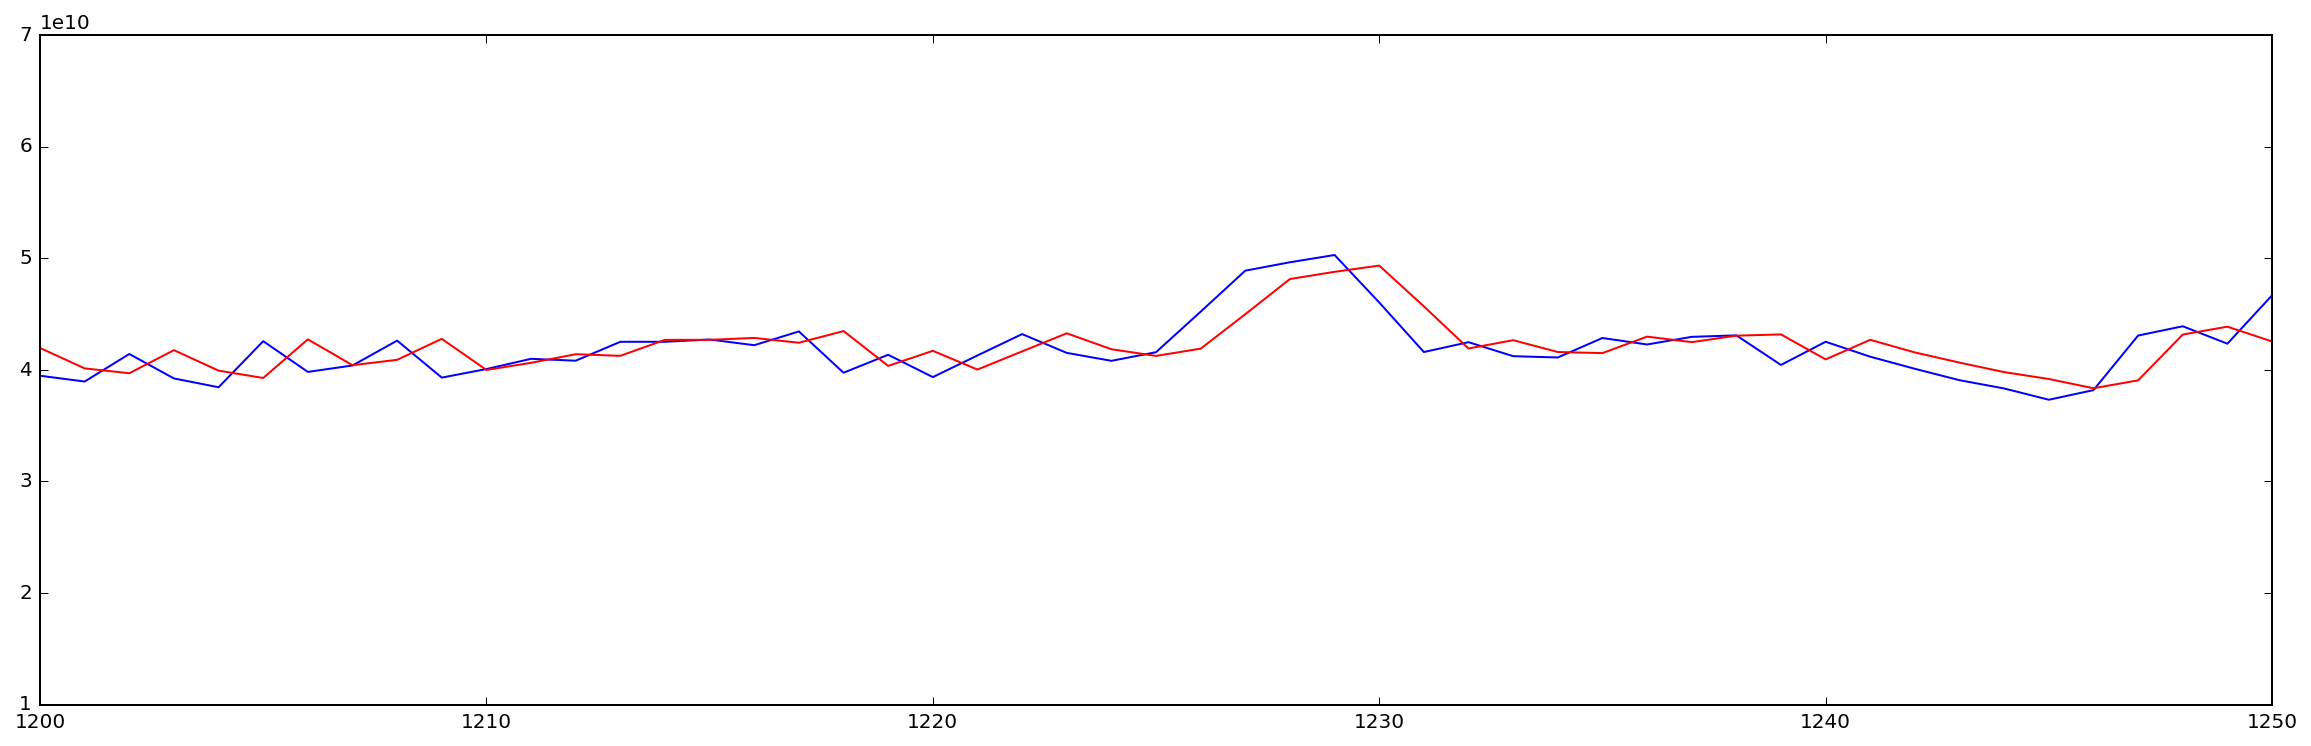

In [64]:
plt.figure(figsize=(20,6))
plt.xlim(1200,1250)
plt.plot(scaler.inverse_transform(dataset_receive))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# How to export model 
To Do

# How to deploy keras model to production environment

To DO

# Result analysis
To DO